# Streetcar Delay Prediction - Deep Learning - REFACTORED

GOAL: predict streetcar delays using a simple Keras model

Refactored to look at delays by hour by day by route by direction

Source dataset: : https://open.toronto.ca/dataset/ttc-streetcar-delay-data/

# Links to key parts of the notebook <a name='linkanchor' />
<a href=#ingestdash>Ingest data</a>

<a href=#definecategories>Define feature categories</a>

<a href=#bookmark>Deal with missing values</a>

<a href=#modelfit>Define and fit model</a>

<a href=#reload>Reload saved model and weights</a>

<a href=#confusionmatrix>Confusion matrix</a>

# Common imports and global variable definitions

In [266]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
# import datetime, timedelta
import datetime
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import math
from subprocess import check_output
import seaborn as sns
from IPython.display import display
#model libraries
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
#import datetime
#from datetime import date
from sklearn import metrics


In [267]:
# set overall parameters

dsxmode = False # overall is this being run in DSX?
csvmode = True # ingest from CSV
dbmode = False # ingest from database
pSpace = True # pSpace mode

testproportion = 0.2 # proportion of data reserved for test set
trainproportion = 0.8 # proportion of non-test data dedicated to training (vs. validation)
verboseout = True
includetext = True # switch to determine whether text fields are included in model
presaved = False # switch to determine whether to train model or load saved model
savemodel = False # switch to determine whether to save model
picklemodel = True # switch for code to allow pickling of Keras model
hctextmax = 7000
maxwords = 6000

targetthresh = 6.0
targetcontinuous = False # switch to determine whether target is continuous or 

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}

#time_of_day = {'overnight':[0,5],'morning_rush':[5,10],
 #             'midday':[10,15],'aft_rush':[15,19],'evening':[19,23]}
              


emptythresh = 6000
# to address imbalance in training data between zero (no delay) and 1 (delay occurred) in refactored, specify weight in compile and fit
# class_weight = {0 : zero_weight, 1: one_weight}
zero_weight = 1.0
# default one_weight
one_weight = 45.878
# additional offset to one_weight
one_weight_offset = 0
patience_threshold = 15


# modifier for saved model elements
modifier = "dec8_50_epoch_val_loss"

# control whether training controlled by early stop
early_stop = True

# hyperparameters
learning_rate = 0.001
dropout_rate = 0.0003 #0.003
l2_lambda = 0.0003 #7.5
loss_func = "binary_crossentropy"
if targetcontinuous:
    output_activation = "linear"
else:
    output_activation = "hard_sigmoid"
    
# date values
date_today = datetime.now()
print("date today",date_today)
start_date =  date(2014, 1, 1)
print("start date",start_date)
end_date = date(2019, 2, 28)
print("end date",end_date)
    
    
# pickled original dataset and post-preprocessing dataset
pickled_data_file = '20142018_0930.pkl'
pickled_dataframe = '2014_2018_df_cleaned_remove_bad_apr23.pkl'



date today 2019-12-08 20:42:58.051011
start date 2014-01-01
end date 2019-02-28


# Helper functions

In [268]:
# time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
#              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':23}}
              

def get_time(hour):
    for tod in time_of_day:
        if (hour >= time_of_day[tod]['start']) and (hour < time_of_day[tod]['end']):
            tod_out = tod
    return(tod_out)

def weekend_time(day, tod):
    if (day=='Saturday') or (day=='Sunday'):
        return('w'+tod)
    else:
        return(tod)
    
      
            

In [269]:
# get the directory for that this notebook is in

def get_path():
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data')) + "/"
    return(path)


# Ingest data and create refactored dataframe
- Ingest data for route information and delay information
- Create refactored dataframe with one row per route / direction / timeslot combination

<a name='ingestdash' />
<a href=#linkanchor>Back to link list</a>

In [270]:
# load list of valid routes and directions into dataframe
def ingest_data(path):
    routedirection_frame = pd.read_csv(path+"routedirection.csv") 
    routedirection_frame.tail()
    file_name = path + pickled_dataframe
    merged_data = pd.read_pickle(file_name)
    merged_data.head()
    return(routedirection_frame, merged_data)

In [271]:
# add derived columns to merged_data dataframe
def prep_merged_data(merged_data):
    # define cols for year month day hour
    merged_data['year'] = pd.DatetimeIndex(merged_data['Report Date']).year
    merged_data['month'] = pd.DatetimeIndex(merged_data['Report Date']).month
    merged_data['daym'] = pd.DatetimeIndex(merged_data['Report Date']).day
    merged_data['hour'] = pd.DatetimeIndex(merged_data['Report Date Time']).hour
    # define time of day column
    merged_data['time_of_day'] = merged_data['hour'].apply(lambda x:get_time(x))
    # add a special timeframe for weekends
    merged_data['time_of_day'] = merged_data.apply(lambda x: weekend_time(x['Day'], x['time_of_day']), axis=1)
    if targetcontinuous:
        merged_data['target'] = merged_data['Min Delay']
    else:
        merged_data['target'] = np.where(merged_data['Min Delay'] >= targetthresh, 1, 0 )
    return(merged_data)

In [272]:
# generate dataframe containing rows for each timeslot for each route for each direction
# and merge with the input merged_data dataframe to get a result of a sparse dataframe with the 
# timeslot / route / direction combinations where delays occurred
def prep_sparse_df(routedirection_frame, merged_data):
    routedirection_frame['count'] = 0
    print("routedirection")
    display(routedirection_frame[:5])
    # define a dataframe with a row for each date to be covered
    days = pd.date_range(start_date, end_date, freq='D')
    date_frame = pd.DataFrame({'date':days,'count':0})
    print("date_frame")
    display(date_frame[:5])
    # define a dataframe with a row for each hour
    hour_list = list(range(0,24))
    hour_frame = pd.DataFrame({'hour':hour_list,'count':0})
    print("hour_frame")
    display(hour_frame[:5])
    #vprint(hour_frame.head())
    # merge date_frame and routedirection
    result1 = pd.merge(date_frame, routedirection_frame, on='count', how='outer')
    print("result1")
    display(result1[:5])
    # merge result1 with hour_frame
    result2 = pd.merge(result1, hour_frame, on='count', how='outer')
    result2 = result2.rename(columns={'date': 'Report Date'})
    result2.Route = result2.Route.astype(str)
    # segment the date
    result2['year'] = pd.DatetimeIndex(result2['Report Date']).year
    result2['month'] = pd.DatetimeIndex(result2['Report Date']).month
    result2['daym'] = pd.DatetimeIndex(result2['Report Date']).day
    result2['day'] = pd.DatetimeIndex(result2['Report Date']).weekday
    print("result2")
    display(result2[:5])
    print("merged_data before")
    display(merged_data[:5])
    # drop extraneous columns from merged_data
    merged_data = merged_data.drop(['Time',
     'Report Date Time',
     'year',
     'month',
     'daym',
     'time_of_day','Min Gap','Location','Incident','Vehicle','target','Day'],axis=1)
    print("merged_data after dropping extraneous columns")
    display(merged_data[:5])
    # join result2 and the trimmed merged_data
    result3 = pd.merge(result2,merged_data ,how='left', on=['Report Date','Route','Direction','hour'])
    result3['Min Delay'].fillna(value=0.0,inplace=True)
    result3['target'] = np.where(result3['Min Delay'] > 0.0, 1, 0 )
    print("result3")
    display(result3[:5])
    return(result3)

    

In [273]:
# REFACTORED DATAFRAME SHOULD HAVE THE FOLLOWING COLUMNS:
# DAY - for every day in the history from Jan 1 2014 to July 31 2018
# HOUR - for every hour of the day
#  for 501, regular route 5:00 am - midnight; 301 overnight
#   for 503: 7- 10:00 am; 4-7:00 pm
# for 504 5:00 am - 2:00 am; 304 overnight
# for 505 5:00 am - 1:00 am
# for 506 5:00 am - 1:00 am; 306 overnight
# for 509 5:00 am - 1:00 am
# for 510 5:00 am - 2:00 am; 310 overnight
# for 511 5:00 am - 1:00 am
# for 512 5:00 am - 2:00 am
# for 514 (Cherry street)
# ROUTE
# DIRECTION
# DELAY - where this could be count OR duration OR binary

# example of filling in values:
# data['PriceDate'] =  pd.to_datetime(data['PriceDate'], format='%m/%d/%Y')
# data = data.sort_values(by=['PriceDate'], ascending=[True])
# data.set_index('PriceDate', inplace=True)
# print (data)

# data = data.resample('D').ffill().reset_index()
# print (data)

# Master Prep Calls
Contains calls to functions to load data, prep input dataframes, and create refactored dataframe

In [274]:
# master calls
# get the path for data files
path = get_path()
print("path is",path)
# load route direction and delay data datframes
directions_df, merged_data = ingest_data(path)
merged_data = prep_merged_data(merged_data)
print("shape of pre refactored dataset", merged_data.shape)
merged_data['year'].value_counts()
merged_data.groupby(['Route','Direction']).size().reset_index().rename(columns={0:'count'}).tail(50)
# create refactored dataframe with one row for each route / direction / timeslot combination
merged_data = prep_sparse_df(directions_df, merged_data)
print("shape of refactored dataset", merged_data.shape)
count_no_delay = merged_data[merged_data['target']==0].shape[0]
count_delay = merged_data[merged_data['target']==1].shape[0]
print("count of no delay ",count_no_delay)
print("count of delay ",count_delay)
# define weighting factor for delay outcome
one_weight = (count_no_delay/count_delay) + one_weight_offset
print("one_weight is ",one_weight)

path is /storage/manning/data/
shape of pre refactored dataset (56205, 17)
routedirection


,Route,Direction,count
0,301,e,0
1,301,w,0
2,301,b,0
3,304,e,0
4,304,e,0


date_frame


,date,count
0,2014-01-01,0
1,2014-01-02,0
2,2014-01-03,0
3,2014-01-04,0
4,2014-01-05,0


hour_frame


,hour,count
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


result1


,date,count,Route,Direction
0,2014-01-01,0,301,e
1,2014-01-01,0,301,w
2,2014-01-01,0,301,b
3,2014-01-01,0,304,e
4,2014-01-01,0,304,e


result2


,Report Date,count,Route,Direction,hour,year,month,daym,day
0,2014-01-01,0,301,e,0,2014,1,1,2
1,2014-01-01,0,301,e,1,2014,1,1,2
2,2014-01-01,0,301,e,2,2014,1,1,2
3,2014-01-01,0,301,e,3,2014,1,1,2
4,2014-01-01,0,301,e,4,2014,1,1,2


merged_data before


,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time,year,month,daym,hour,time_of_day,target
Report Date Time,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01,505,00:00:00,Friday,dundas west stationt to broadview station,General Delay,7.0,14.0,w,4028,2016-01-01 00:00:00,2016,1,1,0,overnight,1
2016-01-01 02:14:00,2016-01-01,511,02:14:00,Friday,fleet st. and strachan,Mechanical,10.0,20.0,e,4018,2016-01-01 02:14:00,2016,1,1,2,overnight,1
2016-01-01 02:22:00,2016-01-01,301,02:22:00,Friday,queen st. west and roncesvalles,Mechanical,9.0,18.0,w,4201,2016-01-01 02:22:00,2016,1,1,2,overnight,1
2016-01-01 03:28:00,2016-01-01,301,03:28:00,Friday,lake shore blvd. and superior st.,Mechanical,20.0,40.0,e,4251,2016-01-01 03:28:00,2016,1,1,3,overnight,1
2016-01-01 14:28:00,2016-01-01,501,14:28:00,Friday,roncesvalles to neville park,Mechanical,6.0,12.0,e,4242,2016-01-01 14:28:00,2016,1,1,14,midday,1


merged_data after dropping extraneous columns


,Report Date,Route,Min Delay,Direction,hour
Report Date Time,,,,,
2016-01-01 00:00:00,2016-01-01,505,7.0,w,0
2016-01-01 02:14:00,2016-01-01,511,10.0,e,2
2016-01-01 02:22:00,2016-01-01,301,9.0,w,2
2016-01-01 03:28:00,2016-01-01,301,20.0,e,3
2016-01-01 14:28:00,2016-01-01,501,6.0,e,14


result3


,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target
0,2014-01-01,0,301,e,0,2014,1,1,2,0.0,0
1,2014-01-01,0,301,e,1,2014,1,1,2,0.0,0
2,2014-01-01,0,301,e,2,2014,1,1,2,0.0,0
3,2014-01-01,0,301,e,3,2014,1,1,2,0.0,0
4,2014-01-01,0,301,e,4,2014,1,1,2,0.0,0


shape of refactored dataset (2540715, 11)
count of no delay  2485837
count of delay  54878
one_weight is  45.297514486679546


In [275]:
merged_data.shape

(2540715, 11)

# Define test / training sets; encode categorical values; process text field


In [276]:
# get training and test data set

train, test = train_test_split(merged_data, test_size = testproportion)
print("Through train test split. Test proportion:")
print(testproportion)



Through train test split. Test proportion:
0.2


# Define feature categories <a name='definecategories' />
<a href=#linkanchor>Back to link list</a>

In [277]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['Report Date', 'count', 'Route', 'Direction', 'hour', 'year', 'month', 'daym', 'day', 'Min Delay', 'target']


In [278]:
# define the required column lists

textcols = [] # columns to deal with as text - replace entries with multiple IDs and use embeddings, RNN
continuouscols = [] # columns to deal with as continuous values - no embeddings
if targetcontinuous:
    excludefromcolist = ['count','Report Date', 'target','count_md','Min Delay'] # columns to exclude completely from the model
    
else:
    # if target column is not renamed Min Delay put Min Delay in exclusion list
    excludefromcolist = ['count','Report Date', 'target','count_md', 'Min Delay'] # columns to exclude completely from the model
# list(set(temp1) - set(temp2))
nontextcols = list(set(allcols) - set(textcols))
collist = list(set(nontextcols) - set(excludefromcolist) - set(continuouscols))

# print column list lengths and contents:
print("allcols",len(allcols))
print("excludefromcolist",len(excludefromcolist))
print(excludefromcolist)
print("textcols",len(textcols))
print(textcols)
print("continuouscols",len(continuouscols))
print(continuouscols)
print("collist",len(collist))
print(collist)

allcols 11
excludefromcolist 5
['count', 'Report Date', 'target', 'count_md', 'Min Delay']
textcols 0
[]
continuouscols 0
[]
collist 7
['month', 'Route', 'Direction', 'day', 'hour', 'year', 'daym']


In [279]:
# ensure continuous columns have numeric type
for col in continuouscols:
    print("col is",col)
    merged_data[col] = merged_data[col].astype(float)
    print("got through one")
    superset_data[col] = superset_data[col].astype(float)

In [280]:
merged_data.dtypes

Report Date    datetime64[ns]
count                   int64
Route                  object
Direction              object
hour                    int64
year                    int64
month                   int64
daym                    int64
day                     int64
Min Delay             float64
target                  int64
dtype: object

# Deal with missing values <a name='bookmark' />
<a href=#linkanchor>Back to link list</a>

In [281]:
# fill missing values

def fill_missing(dataset):
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)





In [282]:
# process categorical data
# replace values with category IDs in the categorical columns
# 


lelist = {}

for col in collist:
    le = LabelEncoder()
    if verboseout:
        print("processing ",col)
    # fit on superset to ensure encoding includes future data but only model on past data
    # np.hstack([superset_data[col]])
    le.fit(np.hstack([merged_data[col]]))
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    lelist[col] = le
    del le
    
    
train.head(5)
    

processing  month


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


processing  Route
processing  Direction
processing  day
processing  hour
processing  year
processing  daym


,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target
2499821,2019-01-29,0,10,4,18,5,0,28,1,0.0,0
2070413,2018-03-17,0,6,0,13,4,2,16,5,0.0,0
2385381,2018-11-05,0,11,3,23,4,10,4,0,0.0,0
1981340,2018-01-10,0,5,1,23,4,0,9,2,0.0,0
1558663,2017-03-02,0,7,1,16,3,2,1,3,17.0,1


In [283]:
# print out correspondance between original values and encodings (for MVP wireframe)

resarray = {}

def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

for col in collist:
    resarray[col] = get_integer_mapping(lelist[col])
    
    

In [284]:
resarray

{'month': {1: 0,
  2: 1,
  3: 2,
  4: 3,
  5: 4,
  6: 5,
  7: 6,
  8: 7,
  9: 8,
  10: 9,
  11: 10,
  12: 11},
 'Route': {'301': 0,
  '304': 1,
  '306': 2,
  '310': 3,
  '501': 4,
  '502': 5,
  '503': 6,
  '504': 7,
  '505': 8,
  '506': 9,
  '509': 10,
  '510': 11,
  '511': 12,
  '512': 13},
 'Direction': {'b': 0, 'e': 1, 'n': 2, 's': 3, 'w': 4},
 'day': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6},
 'hour': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23},
 'year': {2014: 0, 2015: 1, 2016: 2, 2017: 3, 2018: 4, 2019: 5},
 'daym': {1: 0,
  2: 1,
  3: 2,
  4: 3,
  5: 4,
  6: 5,
  7: 6,
  8: 7,
  9: 8,
  10: 9,
  11: 10,
  12: 11,
  13: 12,
  14: 13,
  15: 14,
  16: 15,
  17: 16,
  18: 17,
  19: 18,
  20: 19,
  21: 20,
  22: 21,
  23: 22,
  24: 23,
  25: 24,
  26: 25,
  27: 26,
  28: 27,
  29: 28,
  30: 29,
  31: 30}}

In [285]:
# part 1 of text processing
# tokenize list of text columns (made up of multiple strings)


# text columns that we care about
# textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
# textcols = ['Resolution_Description', 'Subject']

for col in textcols:
    if verboseout:
        print("processing text col",col)
    
    # Tokenizer lower cases and removes punctuation by default
    tok_raw = Tokenizer(num_words=maxwords,lower=True)
    tok_raw.fit_on_texts(train[col])
    train[col] = tok_raw.texts_to_sequences(train[col])
    test[col] = tok_raw.texts_to_sequences(test[col])
    


In [286]:
# define max values for embeddings


max_dict = {}
textmax = 50

for col in collist:
    max_dict[col] = np.max([train[col].max(), test[col].max()])+1
    
# np.max([np.max(train['Resolution_Description'].max()), np.max(train['Subject'].max()),np.max(train['Other_Reason_for_Cancellation'].max()),np.max(train['Reason_for_Reopening'].max())])) 
for cols in textcols:
    maxtrain = np.max(train[(train[cols].map(len) != 0)][cols].map(max))
    maxtest = np.max(test[(test[cols].map(len) != 0)][cols].map(max))
    if verboseout:
        print("maxtrain.max()",maxtrain)
        print("maxtest .max()",maxtest)
    max_dict[cols] = max(maxtrain,maxtest)
    # max_dict[cols] = np.max([np.max(train[cols].max()), np.max(test[cols].max())])+20
    # np.max(df[(df['seq_item_description'].map(len) != 0)].seq_item_description.map(max))
    if max_dict[cols] > textmax:
        textmax = max_dict[cols]

if textmax < hctextmax:
    textmax = hctextmax
        
print("textmax",textmax)
                             
if verboseout:
    print("max_dict",max_dict)



textmax 7000
max_dict {'month': 12, 'Route': 14, 'Direction': 5, 'day': 7, 'hour': 24, 'year': 6, 'daym': 31}


# Split training set into train / validate

In [287]:
# define and scale target and get validation sets

dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)

print(dtrain.shape)
print(dvalid.shape)
if verboseout:
    train["target"].head()

    




/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1626057, 11)
(406515, 11)


In [288]:
# define keras variables


# X for the features used

def get_keras_vars(dataset):
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

def get_keras_list_only(X_in):
    dictlist = []
    for key, value in X_in.items():
        print("X def loop key",key)
        print("value shape",value.shape)
        temp = [key,value]
        dictlist.append(value)
    return dictlist

def get_keras_np(X_in):
    return np.array(list(X_in.items()),dtype=object)
# np.array(list(result.items()), dtype=dtype)

# the deployment API for Watson Studio can only take a list/array, not a dictionary, so define list-only version for input
X_train, X_train_list = get_keras_vars(dtrain)
X_valid, X_valid_list = get_keras_vars(dvalid)
X_test,X_test_list = get_keras_vars(test)
print("keras variables defined")
print("X_train_list",X_train_list)





cat col is month
cat col is Route
cat col is Direction
cat col is day
cat col is hour
cat col is year
cat col is daym
cat col is month
cat col is Route
cat col is Direction
cat col is day
cat col is hour
cat col is year
cat col is daym
cat col is month
cat col is Route
cat col is Direction
cat col is day
cat col is hour
cat col is year
cat col is daym
keras variables defined
X_train_list [array([ 7,  1, 11, ...,  7,  6,  9]), array([ 0,  1, 11, ..., 12,  1,  1]), array([0, 0, 2, ..., 3, 0, 0]), array([1, 6, 4, ..., 2, 5, 4]), array([15, 16, 20, ..., 18, 14, 23]), array([2, 5, 1, ..., 2, 4, 2]), array([ 8, 16, 24, ..., 23, 27,  6])]


In [289]:
X_train_list[0].size

1626057

In [290]:
for x in X_train_list:
    print("size is", x.size)

size is 1626057
size is 1626057
size is 1626057
size is 1626057
size is 1626057
size is 1626057
size is 1626057


# Define and fit model <a name='modelfit' />
<a href=#linkanchor>Back to link list</a>

In [291]:
# define model in Keras

def get_model():
    
          
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    
      
    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # define layers for categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all 
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    
    
    
    # define layers for text columns
    if includetext:    
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col])) 
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")
        
    # define layers for continuous columns
    for col in continuouscols: 
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
    
    
              
    # build up layers
    # main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['Vehicle']) ),Dropout(dropout_rate) (Flatten() (embeddings['Direction']) )])
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings[collist[0]]) ),Dropout(dropout_rate) (Flatten() (embeddings[collist[1]]) )])
    for cols in collist:
        if (cols != collist[0]) & (cols != collist[1]):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])
    
    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])
                                                 
    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])
    
    print("main_l", main_l)                                            
    
       
    
    # define output layer
    output = Dense(1, activation=output_activation) (main_l)
   
    # define model        
                                                  
    model = Model(inputlayerlist, output)
    
       
    # define optimizer
    optimizer = SGD(lr=learning_rate)
   
    # compile model
    model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
         
    
    return model

    
model = get_model()

#plot_model(model, to_file='/home/paperspace/visualizations/streetcarmodel_dec16.png', show_shapes=True, show_layer_names=True)

# output model summary

model.summary()
    

    

about to define embeddings
textmax is 7000
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_66/concat:0", shape=(?, ?), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Route (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_71 (Embedding)        (None, 1, 10)        120         month[0][0]                      
__________________________________________________________________________________________________
embedding_72 (Embedding) 

In [292]:
# set up early stopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience = patience_threshold)
save_model_path = path+'models/'+'scmodel'+modifier+'.h5'
mc = ModelCheckpoint(save_model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [293]:
BATCH_SIZE = 1000
epochs = 50
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",BATCH_SIZE)
print("epochs",epochs)
print("learning_rate",learning_rate)
print("loss function",loss_func)
print("output activation function",output_activation)


model = get_model()
if early_stop:
    modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
        , validation_data=(X_valid_list, dvalid.target), class_weight = {0 : zero_weight, 1: one_weight}, verbose=1,callbacks=[es,mc])
else:
    modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid_list, dvalid.target), class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

text cols []
dropout  0.0003
L2 lambda  0.0003
batch size  1000
epochs 50
learning_rate 0.001
loss function binary_crossentropy
output activation function hard_sigmoid
about to define embeddings
textmax is 7000
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_72/concat:0", shape=(?, ?), dtype=float32)
Train on 1626057 samples, validate on 406515 samples
Epoch 1/50
1626057/1626057 [==============================] - 20s 12us/step - loss: 1.0458 - acc: 0.6050 - weighted_acc: 1.4161 - val_loss: 0.5679 - val_acc: 0.6746 - val_weighted_acc: 0.6746

Epoch 00001: val_loss improved from inf to 0.56786, saving model to /storage/manning/data/models/scmodeldec8_50_epoch_val_loss.h5
Epoch 2/50
1626057/1626057 [==============================] - 13s 8us/step - loss: 1.0070 - acc: 0.7018 - weighted_acc: 1.4743 - val_loss: 0.5376 - val_acc: 0.7167 - val_weighted_acc: 0.7167

Epoch 00002: val_loss improved from 0.56786 to 0.53763, saving model to /storage/

In [294]:
# save model elements explicitly if not saved as part of early_stop
if early_stop == False:
    model_json = model.to_json()
    with open(path+'models/'+'model'+modifier+'.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(path+'models/'+'scweights'+modifier+'.h5')
    
    # save tokenizer tok_raw for text and label encoder for categorical cols
    
      
    model.save(save_model_path)
    print("Saved model, weights to disk")


In [295]:
saved_model = load_model(save_model_path)
_, train_acc = saved_model.evaluate(X_train_list, dtrain.target, verbose=0)
_, test_acc = saved_model.evaluate(X_test, test.target, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.736, Test: 0.736


In [296]:
X_train_list

[array([ 7,  1, 11, ...,  7,  6,  9]),
 array([ 0,  1, 11, ..., 12,  1,  1]),
 array([0, 0, 2, ..., 3, 0, 0]),
 array([1, 6, 4, ..., 2, 5, 4]),
 array([15, 16, 20, ..., 18, 14, 23]),
 array([2, 5, 1, ..., 2, 4, 2]),
 array([ 8, 16, 24, ..., 23, 27,  6])]

In [297]:
X_train_list[0]

array([ 7,  1, 11, ...,  7,  6,  9])

# Load saved model and weights <a name='reload' />
<a href=#linkanchor>Back to link list</a>

In [298]:
saved_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Route (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_78 (Embedding)        (None, 1, 10)        120         month[0][0]                      
__________________________________________________________________________________________________
embedding_79 (Embedding)        (None, 1, 10)        140         Route[0][0]                      
__________________________________________________________________________________________________
Direction 

In [299]:
if presaved == True:
    BATCH_SIZE = 1000
    epochs = 1
    modelfit2 = loaded_model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid_list, dvalid.target), verbose=1)

# Predictions and renderings

In [300]:
# functions to parse and manipulate dates in the style of the input CSVs

def create_date(year,month):
    outdate = datetime.date(year,month,15)
    return(outdate)

def parse_bic_date(bic_date_in):
    year = int(bic_date_in[0:4])
    month = int(bic_date_in[-2:])
    return(year,month)

def create_date_from_bic(bic_date_in):
    yr,mth = parse_bic_date(bic_date_in)
    retdate = create_date(yr,mth)
    return retdate

def get_datecomp_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b').month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (year,month,day)

def get_date_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (date(year,month,day))

def get_year_from_csvdate (csv_date):
    year = int('20'+csv_date[-2:])
    return (year)

def get_month_from_csvdate (csv_date):
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    return (month)

def get_day_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    return (day)

def get_weekday (date):
    return(date.weekday())

# pd.to_datetime(x, coerce=True)

def validatedate(csv_text):
    try:
        datetime.datetime.strptime(csv_date[3:6], '%b')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [301]:
type(X_test)

dict

In [302]:
list(X_test_list[0])

[11,
 10,
 8,
 9,
 2,
 8,
 6,
 8,
 4,
 7,
 4,
 11,
 5,
 5,
 8,
 8,
 3,
 11,
 3,
 7,
 4,
 0,
 6,
 6,
 4,
 6,
 11,
 1,
 7,
 5,
 1,
 7,
 2,
 5,
 2,
 11,
 1,
 11,
 4,
 6,
 3,
 6,
 4,
 3,
 8,
 1,
 9,
 1,
 2,
 8,
 9,
 9,
 11,
 0,
 3,
 1,
 1,
 1,
 0,
 4,
 7,
 3,
 3,
 10,
 2,
 8,
 0,
 2,
 10,
 1,
 1,
 2,
 5,
 9,
 10,
 2,
 9,
 0,
 1,
 8,
 11,
 2,
 4,
 1,
 8,
 3,
 0,
 6,
 8,
 0,
 1,
 6,
 9,
 8,
 3,
 9,
 10,
 7,
 3,
 1,
 0,
 9,
 4,
 4,
 0,
 6,
 6,
 2,
 4,
 2,
 1,
 5,
 4,
 5,
 3,
 0,
 8,
 5,
 0,
 2,
 10,
 1,
 2,
 3,
 8,
 4,
 9,
 7,
 7,
 11,
 2,
 11,
 8,
 4,
 2,
 8,
 7,
 11,
 7,
 0,
 5,
 11,
 1,
 1,
 9,
 0,
 0,
 8,
 4,
 0,
 10,
 1,
 11,
 5,
 0,
 0,
 9,
 7,
 5,
 3,
 3,
 11,
 2,
 11,
 6,
 10,
 3,
 10,
 5,
 7,
 3,
 5,
 6,
 0,
 7,
 0,
 5,
 8,
 6,
 7,
 6,
 5,
 11,
 10,
 7,
 5,
 6,
 1,
 8,
 3,
 1,
 1,
 2,
 1,
 9,
 7,
 11,
 3,
 6,
 4,
 0,
 10,
 5,
 4,
 0,
 9,
 5,
 4,
 11,
 5,
 8,
 11,
 6,
 0,
 5,
 4,
 6,
 0,
 9,
 10,
 6,
 7,
 5,
 3,
 6,
 8,
 9,
 1,
 6,
 7,
 5,
 11,
 7,
 7,
 2,
 7,
 6,
 6,
 8,
 10,
 10,
 5

In [303]:
print("X_test ", X_test)

X_test  {'month': array([11, 10,  8, ...,  0,  2,  1]), 'Route': array([12, 12,  8, ...,  0,  0,  2]), 'Direction': array([1, 0, 2, ..., 4, 0, 0]), 'day': array([2, 0, 4, ..., 5, 5, 0]), 'hour': array([ 4,  6,  7, ...,  1,  3, 14]), 'year': array([2, 3, 0, ..., 4, 1, 0]), 'daym': array([ 6,  5, 18, ...,  5,  6,  9])}


In [304]:
# predictions on training set

preds = saved_model.predict(X_test, batch_size=BATCH_SIZE)

In [305]:
preds.shape

(508143, 1)

In [306]:
preds[:50]

array([[0.4342232 ],
       [0.22817555],
       [0.47977874],
       [0.        ],
       [0.        ],
       [0.2165623 ],
       [0.34537435],
       [0.15547857],
       [0.44244584],
       [0.        ],
       [0.32277852],
       [0.4378117 ],
       [0.40350258],
       [0.89690137],
       [0.23243538],
       [0.        ],
       [0.9290977 ],
       [0.80052024],
       [0.10636863],
       [0.3926186 ],
       [0.5959369 ],
       [0.75198364],
       [0.27023253],
       [0.4266712 ],
       [0.4317145 ],
       [0.24172214],
       [0.24368563],
       [0.64353365],
       [0.        ],
       [0.2966574 ],
       [0.2750958 ],
       [0.        ],
       [0.4558023 ],
       [0.64204204],
       [0.16736534],
       [0.25151   ],
       [0.66892725],
       [0.25163174],
       [0.45662874],
       [0.34908998],
       [0.63074577],
       [0.        ],
       [0.83350635],
       [0.4285274 ],
       [0.        ],
       [0.43694225],
       [0.        ],
       [0.786

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


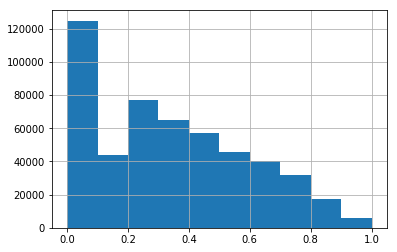

In [307]:
test["predict"] = preds
test.predict[:5]
if verboseout:
    test.predict.hist()

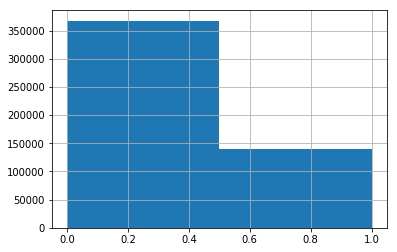

In [308]:
if verboseout:
    test.predict.hist(bins=2)

In [309]:
# print(type(apar_ds['Time_to_relief'].iloc[0]))
print(type(preds))
print(preds.shape)
print(type(test.target))

<class 'numpy.ndarray'>
(508143, 1)
<class 'pandas.core.series.Series'>


In [310]:
# get rounded predictions 
test["predround"] = preds.round().astype(int)
test.predround[:5]

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1444588    0
1894476    0
352388     0
2360192    0
2071465    0
Name: predround, dtype: int64

In [311]:
print("test target 0",test[test['target']==0].shape[0])
print("test target 1",test[test['target']==1].shape[0])
print("test predround 0",test[test['predround']==0].shape[0])
print("test predround 1",test[test['predround']==1].shape[0])

test target 0 497090
test target 1 11053
test predround 0 367521
test predround 1 140622


In [312]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(test.target[:100000] - test.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct test")
print((len(deltatr) - deltatr.sum())/len(deltatr))



26435
percentage correct test
0.73565


In [313]:
# predict values for validation X values
# X_valid, dvalid.target
predval = model.predict(X_valid, batch_size=BATCH_SIZE)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


1157448    0.431010
2128326    0.110531
25255      0.016092
1119501    0.559013
1377454    0.000000
Name: predict, dtype: float32

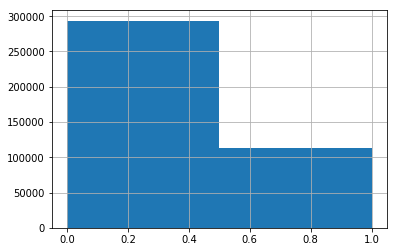

In [314]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [315]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


1157448    0
2128326    0
25255      0
1119501    1
1377454    0
188248     0
119416     0
411629     0
1866195    0
2334276    1
Name: deltaval, dtype: int64
107988


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [316]:
# hand calculation of proportion correct guesses in validation set

test["deltaval"] = abs(test.target - test.predround)
print(test["deltaval"][:10])
print(test["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))

1444588    0
1894476    0
352388     0
2360192    0
2071465    0
826264     0
1740459    0
1829503    0
2158175    0
1275322    0
Name: deltaval, dtype: int64
134341


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [317]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target,predround,predict,deltaval
1119501,2016-04-10,0,8,4,20,2,3,9,6,0.0,0,1,0.559013,1
2334276,2018-09-28,0,13,1,2,4,8,27,4,0.0,0,1,0.559168,1
2190810,2018-06-14,0,9,1,19,4,5,13,3,0.0,0,1,0.691914,1
1911761,2017-11-19,0,11,1,5,3,10,18,6,0.0,0,1,0.711171,1
1081471,2016-03-13,0,8,1,22,2,2,12,6,0.0,0,1,0.542856,1
642330,2015-04-22,0,9,1,23,1,3,21,2,0.0,0,1,0.605007,1
339865,2014-09-10,0,4,4,23,0,8,9,2,0.0,0,1,0.704958,1
843085,2015-09-18,0,9,3,17,1,8,17,4,0.0,0,1,0.547053,1
318997,2014-08-25,0,11,4,7,0,7,24,0,0.0,0,1,0.671596,1
1497167,2017-01-15,0,11,4,7,3,0,14,6,0.0,0,1,0.672291,1


In [318]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
testwrong = test.loc[(test.deltaval == 1)]
testright = test.loc[(test.deltaval == 0)]
testwrong.head(20)

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target,predict,predround,deltaval
2203877,2018-06-24,0,4,1,14,4,5,23,6,0.0,0,0.896901,1,1
1341532,2016-09-22,0,6,0,17,2,8,21,3,64.0,1,0.000000,0,1
1132617,2016-04-20,0,4,4,7,2,3,19,2,0.0,0,0.929098,1,1
475099,2014-12-19,0,9,4,7,0,11,18,4,0.0,0,0.800520,1,1
1640183,2017-05-01,0,13,1,19,3,4,0,0,0.0,0,0.595937,1,1
519594,2015-01-21,0,9,4,9,1,0,20,2,0.0,0,0.751984,1,1
1035448,2016-02-08,0,7,4,3,2,1,7,0,0.0,0,0.643534,1,1
729595,2015-06-26,0,7,1,3,1,5,25,4,0.0,0,0.642042,1,1
42411,2014-02-01,0,8,4,12,0,1,0,5,0.0,0,0.668927,1,1
614397,2015-04-01,0,12,1,16,1,3,0,2,0.0,0,0.630746,1,1


In [319]:
testright.head(20)

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target,predict,predround,deltaval
1444588,2016-12-07,0,12,1,4,2,11,6,2,0.0,0,0.434223,0,0
1894476,2017-11-06,0,12,0,6,3,10,5,0,0.0,0,0.228176,0,0
352388,2014-09-19,0,8,2,7,0,8,18,4,0.0,0,0.479779,0,0
2360192,2018-10-18,0,2,0,20,4,9,17,3,0.0,0,0.000000,0,0
2071465,2018-03-18,0,2,0,9,4,2,17,6,0.0,0,0.000000,0,0
826264,2015-09-06,0,2,4,18,1,8,5,6,0.0,0,0.216562,0,0
1740459,2017-07-15,0,7,3,3,3,6,14,5,0.0,0,0.345374,0,0
1829503,2017-09-19,0,9,0,4,3,8,18,1,0.0,0,0.155479,0,0
2158175,2018-05-21,0,7,3,23,4,4,20,0,0.0,0,0.442446,0,0
1275322,2016-08-04,0,3,3,14,2,7,3,3,0.0,0,0.000000,0,0


In [320]:
dvalidright.head(20)

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target,predround,predict,deltaval
1157448,2016-05-08,0,10,4,12,2,4,7,6,0.0,0,0,0.431010,0
2128326,2018-04-29,0,6,4,20,4,3,28,6,0.0,0,0,0.110531,0
25255,2014-01-19,0,10,0,16,0,0,18,6,0.0,0,0,0.016092,0
1377454,2016-10-19,0,1,2,3,2,9,18,2,0.0,0,0,0.000000,0
188248,2014-05-20,0,10,0,4,0,4,19,1,0.0,0,0,0.000000,0
119416,2014-03-30,0,10,1,3,0,2,29,6,0.0,0,0,0.234541,0
411629,2014-11-02,0,7,0,15,0,10,1,6,0.0,0,0,0.400151,0
1866195,2017-10-16,0,12,3,4,3,9,15,0,0.0,0,0,0.148046,0
43814,2014-02-02,0,8,3,23,0,1,1,6,0.0,0,0,0.219106,0
535376,2015-02-02,0,5,0,0,1,1,1,0,0.0,0,0,0.000000,0


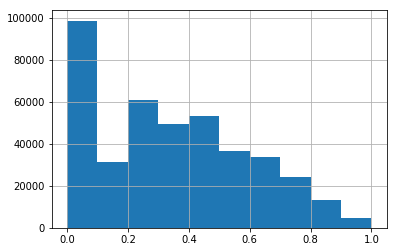

In [321]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

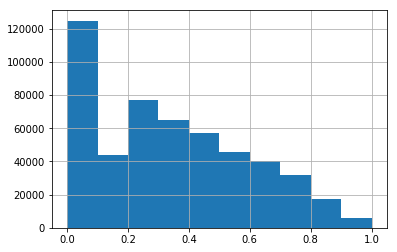

In [322]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
test.predict.hist()

In [323]:
# ,encoding = "ISO-8859-1"
'''if dsxmode == False:
    dvalidwrong.to_csv('/home/paperspace/data/dmprediction/dvalidwrongmay20.csv')'''

"if dsxmode == False:\n    dvalidwrong.to_csv('/home/paperspace/data/dmprediction/dvalidwrongmay20.csv')"

In [324]:
test.target[:50]

1444588    0
1894476    0
352388     0
2360192    0
2071465    0
826264     0
1740459    0
1829503    0
2158175    0
1275322    0
196225     0
452548     0
1219857    0
2203877    0
2323598    0
1341532    1
1132617    0
475099     0
1606221    0
1779959    0
1640183    0
519594     0
1757310    0
1747673    0
2168341    0
2214122    0
1955404    0
1035448    0
808426     0
2199245    0
2538250    0
1274147    0
79966      0
729595     0
1597028    0
2440273    0
42411      0
1447348    0
2166004    0
1736218    0
614397     0
1721532    0
2156522    0
139834     0
1834161    0
55541      0
2373684    0
2028480    1
1086375    0
1839235    0
Name: target, dtype: int64

In [325]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dvalid.target[:100000] - dvalid.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct validate")
print((len(deltatr) - deltatr.sum())/len(deltatr))


26671
percentage correct validate
0.73329


dict_keys(['val_loss', 'val_acc', 'val_weighted_acc', 'loss', 'acc', 'weighted_acc'])


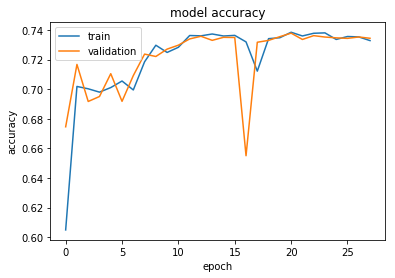

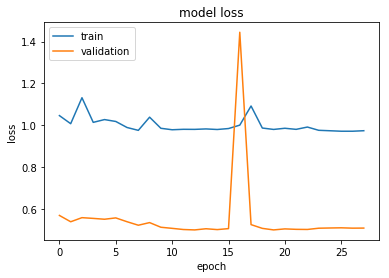

In [326]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
plt.plot(modelfit.history['acc'])
plt.plot(modelfit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Confusion matrix <a name='confusionmatrix' />
<a href=#linkanchor>Back to link list</a>

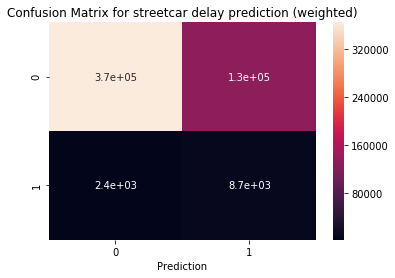

In [327]:


cfmap=metrics.confusion_matrix(y_true=test['target'],  # True labels
                         y_pred=test["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for streetcar delay prediction (weighted)")
plt.show()

In [328]:
model.metrics_names

['loss', 'acc', 'weighted_acc']

# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl

# Summary
This notebook shows methods for dealing with structured data in the context of a neural network.

# Author

Mark Ryan is a manager at Intact Insurance.